In [2]:
%matplotlib inline
from __future__ import division, absolute_import

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from skimage import color 


## Now to find the edges of the image pair

* images are first cropped to likely stereocard
* a check should be run to check for case where stereocard cropping actually cropped to image pair

In [3]:
card = Image.open('./fl_cards/G90F121_003F.jpg')

In [7]:
w, h = card.size

In [9]:
w_slice = card.crop((0, np.round(h * 1/3), w, np.round(h * 2/3)))

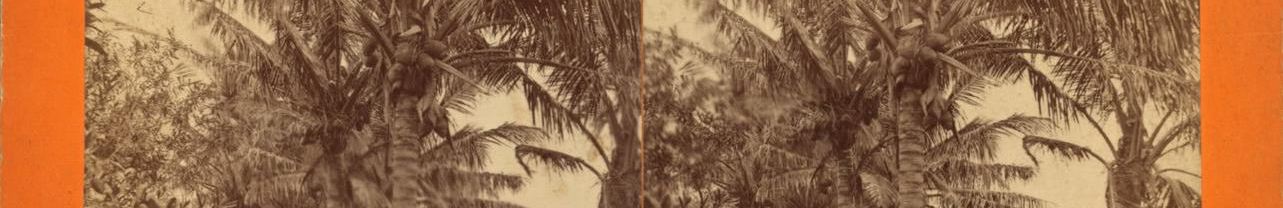

In [11]:
w_slice

In [12]:
h_slice = card.crop((np.round(w * 1/3), 0, np.round(w * 2/3), h))

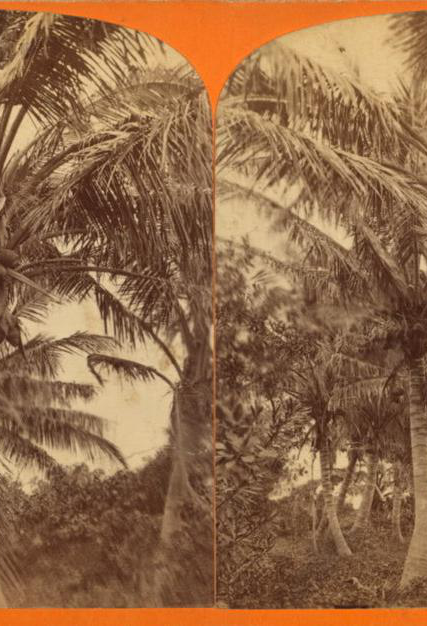

In [13]:
h_slice

In [36]:
def special_gray(image_slice):
    ycbcr = color.rgb2ycbcr(image_slice)
    
    cb_invert = 255 - ycbcr[:, :, 1]
    
    # Combine and Normalize to create gray
    return (cb_invert + ycbcr[:, :, 2]) / 510


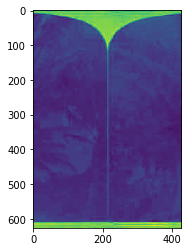

In [37]:
plt.imshow(special_gray(h_slice))
plt.show()

In [38]:
gray_w = special_gray(w_slice)
gray_h = special_gray(h_slice)

In [39]:
intensities_w = np.squeeze(np.dot(gray_w.T, np.ones((gray_w.shape[0], 1))))

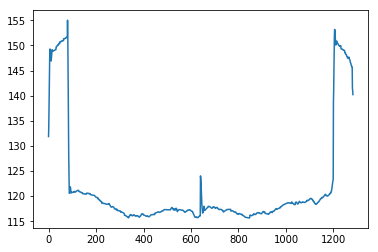

In [40]:
plt.plot(intensities_w)
plt.show()

In [44]:
intensities_h = np.squeeze(np.dot(gray_h, np.ones((gray_h.shape[1], 1))))

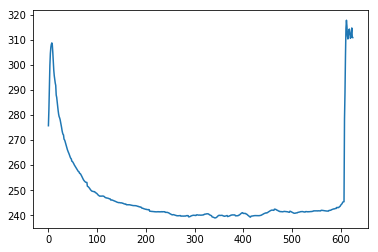

In [45]:
plt.plot(intensities_h)
plt.show()

### Time for Stats

In [46]:
from scipy.stats import norm

In [52]:
x0 = {'x': 0.00418, 'mu': 0.0865, 'sigma': 0.0266}
x1 = {'x': 0.003, 'mu': 0.9143, 'sigma': 0.025}

In [78]:
w = w_slice.size[0]

bias_l = {'x': x0['x'] * w, 'mu': x0['mu'] * w, 'sigma': x0['sigma'] * w}
bias_r = {'x': x1['x'] * w, 'mu': x1['mu'] * w, 'sigma': x1['sigma'] * w}

bias_l

{'x': 5.36294, 'mu': 110.97949999999999, 'sigma': 34.1278}

In [67]:
test = bias_l['x'] * norm.pdf(range(1, w), bias_l['mu'], bias_l['sigma'])

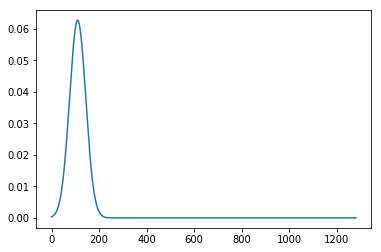

In [68]:
plt.plot(test)
plt.show()

In [165]:
l_term = bias_l['x'] * norm.pdf(range(0, w), bias_l['mu'], bias_l['sigma'])
r_term = bias_r['x'] * norm.pdf(range(0, w), bias_r['mu'], bias_r['sigma'])

bias_term = (l_term + r_term)

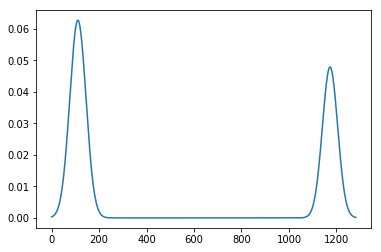

In [166]:
plt.plot(bias_term)
plt.show()

In [167]:
biased_w = bias_term * intensities_w

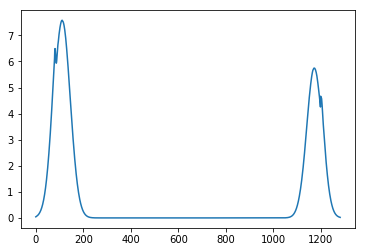

In [168]:
plt.plot(biased_w)
plt.show()

### Signal Processing time

In [76]:
from scipy.signal import find_peaks

In [89]:
peaks = find_peaks(biased_w)[0]
peaks

array([  81,  111, 1173, 1200])

In [90]:
# find_peaks(intensities_w, prominence=1)

In [96]:
def return_bounds(peaks, width):
    num_peaks = len(peaks)
    
    if num_peaks < 2:
        # Failsafe, return average results
        x0 = np.round(width * 0.1)
        x1 = np.round(wdith * 0.9)
    elif num_peaks == 2:
        # Twin Peaks found
        x0 = peaks[0]
        x1 = peaks[1]
    else:
        # pare down list to get most likely right and left values
        # left value is < 30% width
        # right value is > 70% width
        x0_locs = np.round(0.3 * width)
        x1_locs = np.round(0.7 * width)
        
        x0_pool = peaks[peaks < x0_locs]
        x1_pool = peaks[peaks > x1_locs]
        
        x0 = x0_pool
        
    return x0
        

In [101]:
def pare_down_peaks(peaks, width):
    # left value is < 30% width
    # right value is > 70% width
    x0_locs = np.round(0.3 * width)
    x1_locs = np.round(0.7 * width)

    x0_pool = peaks[peaks < x0_locs]
    x1_pool = peaks[peaks > x1_locs]
    
    return (x0_pool, x1_pool)

In [136]:
x0_pool, x1_pool = pare_down_peaks(peaks, w)
largest_pool = np.max([len(x0_pool), len(x1_pool)])

In [137]:
combinations = np.array(np.meshgrid(x0_pool, x1_pool)).T.reshape(-1, largest_pool)

In [138]:
combinations

array([[  81, 1173],
       [  81, 1200],
       [ 111, 1173],
       [ 111, 1200]])

In [140]:
combinations.shape

(4, 2)

In [156]:
combinations = np.array(np.meshgrid(x0_pool, x1_pool)).T.reshape(-1, largest_pool)
img_pair_size = (combinations[:, 1] - combinations[:, 0]) / w
est_card_size = (combinations[:, 1] + combinations[:, 0]) / w

In [150]:
est_card_size

array([0.97739673, 0.99844115, 1.00077942, 1.02182385])

In [157]:
mid_truth = np.greater(img_pair_size, np.ones_like(img_pair_size) * 0.7)
size_truth = np.isclose(est_card_size, np.ones_like(img_pair_size), rtol=0.02)
pool_truth = np.logical_and(mid_truth, size_truth)

In [158]:
pool_truth

array([False,  True,  True, False])